<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import stanza
import spacy_stanza

nlp = spacy_stanza.load_pipeline("es")

C:\Users\Alejandro\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-14 20:00:00 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-05-14 20:00:00 INFO: Use device: cpu
2023-05-14 20:00:00 INFO: Loading: tokenize
2023-05-14 20:00:00 INFO: Loading: mwt
2023-05-14 20:00:00 INFO: Loading: pos
2023-05-14 20:00:00 INFO: Loading: lemma
2023-05-14 20:00:00 INFO: Loading: depparse
2023-05-14 20:00:01 INFO: Loading: ner
2023-05-14 20:00:03 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [3]:
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [4]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buenas", "Buenos días", "Buenas tardes"],
              "responses": ["Hola, bienvenido a AleBOT. Para conocer las opciones escribi opciones"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "Como te llamas?"],
              "responses": ["Mi nombre es AleBOT", "Yo soy AleBOT"]
             },
             {"tag": "opciones",
              "patterns": ["ayuda", "opciones", "que podes hacer?", "menu", "informacion", ""],
              "responses": ["Escribí: \n-contacto: información de contacto \n-reservas: información de reservas \n-delivery: envios a domicilio"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿hacen envios?", "tienen delivery?", "Como es el delivery?", "Tienen envios a domicilio?"],
              "responses": ["Hacemos envíos en CABA, todos los días de 8:00 a 22:00"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?", "Carta", "Menu"],
              "responses": ["En el siguiente link podrás encontrar los precios"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "reservas",
              "patterns": ["Hacen reservas?", "¿Puedo hacer una reserva?", "quiero reservar"],
              "responses": ["Para reservar, podes hacerlo a traves de nuestra web o por whatsapp"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["AleBot a la orden"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Nos vemos", "Adios"],
              "responses": ["Saludos! Te esperamos!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [5]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def tokenizer_func(text):
    return nlp(preprocess_clean_text(text))

doc_lowered = []
training = []
out_empty = [0] * len(classes)

stop_words1 = ["que", "como", "donde", "cuando", "y", "de", "hacer"]

for idx, doc in enumerate(doc_X):
    doc_lowered.append(doc.lower())


# Crear un vectorizar TFIDF que quite las "stop words" del ingles y utilice
# nuestra funcion para obtener los tokens lematizados "get_processed_text"
word_vectorizer = TfidfVectorizer(tokenizer=tokenizer_func, stop_words=stop_words1)

# Crear los vectores a partir del corpus
all_word_vectors = word_vectorizer.fit_transform(doc_lowered)
all_word_vectors = all_word_vectors.toarray()

for idx, doc in enumerate(doc_X):
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    training.append([all_word_vectors[idx], output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

c:\Users\Alejandro\anaconda3\envs\pnl\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Alejandro\anaconda3\envs\pnl\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [hacer, y, cuando, donde, como, de, que] not in stop_words.
  warnings.warn(


In [107]:
input_text = "Hola que tal todo bien? reservas envios"
input_x = []
input_x.append(input_text)
word_vectors = word_vectorizer.transform(input_x)
word_vectors = word_vectors.toarray()
word_vectors

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [94]:

input = "Hola que tal todo bien?"
tokens_in = nlp(preprocess_clean_text(input.lower()))
words_in = []
for token in tokens_in:            
    words_in.append(token.lemma_)

X_in = []
X_in.append(words_in)
print(words_in)
'''
for idx, doc in enumerate(doc_X):
    doc_lowered.append(doc.lower())
word_vectorizer.transform("hola como va")
'''

['holar', 'que', 'tal', 'todo', 'bien']


'\nfor idx, doc in enumerate(doc_X):\n    doc_lowered.append(doc.lower())\nword_vectorizer.transform("hola como va")\n'

In [6]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

### 5 - Entrenamiento del modelo

In [7]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (56,) output: 10


In [8]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7296      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 16,202
Trainable params: 16,202
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 7s 8ms/step - loss: 2.3122 - accuracy: 0.1591
Epoch 2/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3510 - accuracy: 0.0455
Epoch 3/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3552 - accuracy: 0.1136
Epoch 4/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2561 - accuracy: 0.2045
Epoch 5/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2343 - accuracy: 0.1364
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2820 - accuracy: 0.1364
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2570 - accuracy: 0.1364
Epoch 8/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2890 - accuracy: 0.0909
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.2355 - accuracy: 0.2045
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 2.1583 - accuracy: 0.2727
Epoch 11/200
2/2 [===========

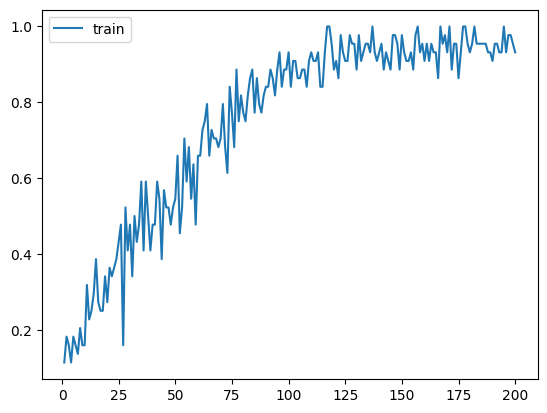

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

### 6 - Testing y validación

In [10]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [11]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: Hola
1/1 [==============================] - 0s 154ms/step
BOT: Hola, bienvenido a AleBOT. Para conocer las opciones escribi opciones
Q: opciones
1/1 [==============================] - 0s 25ms/step
BOT: Escribí: 
-contacto: información de contacto 
-reservas: información de reservas 
-delivery: envios a domicilio
Q: reservas
1/1 [==============================] - 0s 34ms/step
BOT: Para reservar, podes hacerlo a traves de nuestra web o por whatsapp
Q: delivery
1/1 [==============================] - 0s 30ms/step
BOT: Hacemos envíos en CABA, todos los días de 8:00 a 22:00
Q: contacto
1/1 [==============================] - 0s 31ms/step
BOT: Contactos al whatsapp <numero>
Q: chau
1/1 [==============================] - 0s 31ms/step
BOT: Saludos! Te esperamos!
Q: 
BOT: Perdón, no comprendo la pregunta.
Q: 
BOT: Perdón, no comprendo la pregunta.
Q: 
BOT: Perdón, no comprendo la pregunta.


KeyboardInterrupt: Interrupted by user

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

Filtrar los stop words puede ayudar a que el modelo tenga una performance mayor. En este caso, palabras como "como", "de", "que" y otras mas pueden confundir al modelo ya que son palabras que forman parte del vocabulario pero que no aportan informacion sobre que clase pertenece la respuesta correcta. En casos donde el usuario haga una consulta utilizando estos terminos, el bot podria responder incorrectamente, dandole mas importancia a los conectores que a la frase en si.
TFIDF tambien puede ayudar a reducir este tipo de problemas. Al quitarle importancia a terminos que se encuentren muy repetidos en el vocabulario, los conectores o palabras que esten en varias de las clases influiran menos en la decision final del modelo.